## DENCE NET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.6.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 1998 images belonging to 6 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 1998 images belonging to 6 classes.


In [5]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 6

K.clear_session()
model = densenet(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
model_path = "DENCE.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 100
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/100
3/3 [==============================] - 178s 48s/step - loss: 2.3191 - accuracy: 0.3958 - precision: 0.5000 - val_loss: 1.6749 - val_accuracy: 0.2604 - val_precision: 0.0000e+00

Epoch 00001: accuracy improved from -inf to 0.39583, saving model to DENCE.h5
Epoch 2/100
3/3 [==============================] - 132s 40s/step - loss: 2.5674 - accuracy: 0.4872 - precision: 0.5205 - val_loss: 2.3467 - val_accuracy: 0.2604 - val_precision: 0.2889

Epoch 00002: accuracy improved from 0.39583 to 0.48718, saving model to DENCE.h5
Epoch 3/100
3/3 [==============================] - 221s 78s/step - loss: 1.0869 - accuracy: 0.6562 - precision: 0.6854 - val_loss: 7.1115 - val_accuracy: 0.1979 - val_precision: 0.2881

Epoch 00003: accuracy improved from 0.48718 to 0.65625, saving model to DENCE.h5
Epoch 4/100
3/3 [==============================] - 129s 42s/step - loss: 1.1384 - accuracy: 0.6458 - precision: 0.6818 - val_loss: 18.2241 - val_accuracy: 0.1562 - val_precision: 0.2542

Epoch 00004

3/3 [==============================] - 152s 67s/step - loss: 0.8219 - accuracy: 0.7188 - precision: 0.7143 - val_loss: 2.0143 - val_accuracy: 0.2812 - val_precision: 0.2468

Epoch 00034: accuracy did not improve from 0.86458
Epoch 35/100
3/3 [==============================] - 163s 65s/step - loss: 0.7623 - accuracy: 0.7292 - precision: 0.7419 - val_loss: 1.7762 - val_accuracy: 0.2500 - val_precision: 0.3519

Epoch 00035: accuracy did not improve from 0.86458
Epoch 36/100
3/3 [==============================] - 98s 32s/step - loss: 0.4330 - accuracy: 0.8750 - precision: 0.8901 - val_loss: 1.8042 - val_accuracy: 0.2917 - val_precision: 0.3478

Epoch 00036: accuracy improved from 0.86458 to 0.87500, saving model to DENCE.h5
Epoch 37/100
3/3 [==============================] - 151s 66s/step - loss: 0.6096 - accuracy: 0.7396 - precision: 0.7640 - val_loss: 1.8691 - val_accuracy: 0.2604 - val_precision: 0.2683

Epoch 00037: accuracy did not improve from 0.87500
Epoch 38/100
3/3 [==============

3/3 [==============================] - 70s 26s/step - loss: 0.5812 - accuracy: 0.7500 - precision: 0.7802 - val_loss: 5672.6343 - val_accuracy: 0.1875 - val_precision: 0.2143

Epoch 00068: accuracy did not improve from 0.87500
Epoch 69/100
3/3 [==============================] - 78s 27s/step - loss: 2.7339 - accuracy: 0.7604 - precision: 0.7907 - val_loss: 5063.2437 - val_accuracy: 0.2083 - val_precision: 0.2045

Epoch 00069: accuracy did not improve from 0.87500
Epoch 70/100
3/3 [==============================] - 98s 37s/step - loss: 0.5382 - accuracy: 0.8125 - precision: 0.8276 - val_loss: 3557.9941 - val_accuracy: 0.2292 - val_precision: 0.2283

Epoch 00070: accuracy did not improve from 0.87500
Epoch 71/100
3/3 [==============================] - 94s 34s/step - loss: 0.6055 - accuracy: 0.7396 - precision: 0.7753 - val_loss: 1530.0576 - val_accuracy: 0.2396 - val_precision: 0.2421

Epoch 00071: accuracy did not improve from 0.87500
Epoch 72/100
3/3 [==============================] - 8

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

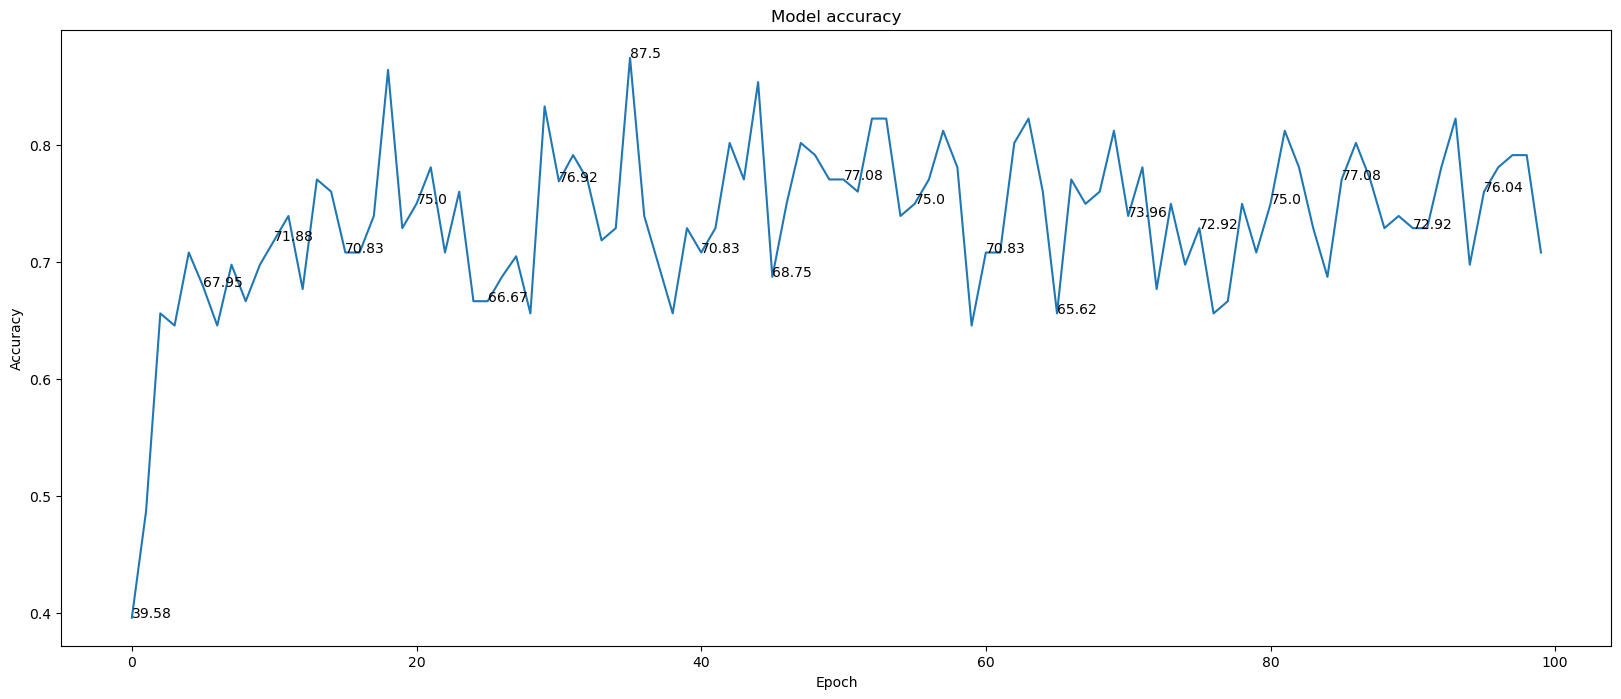

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

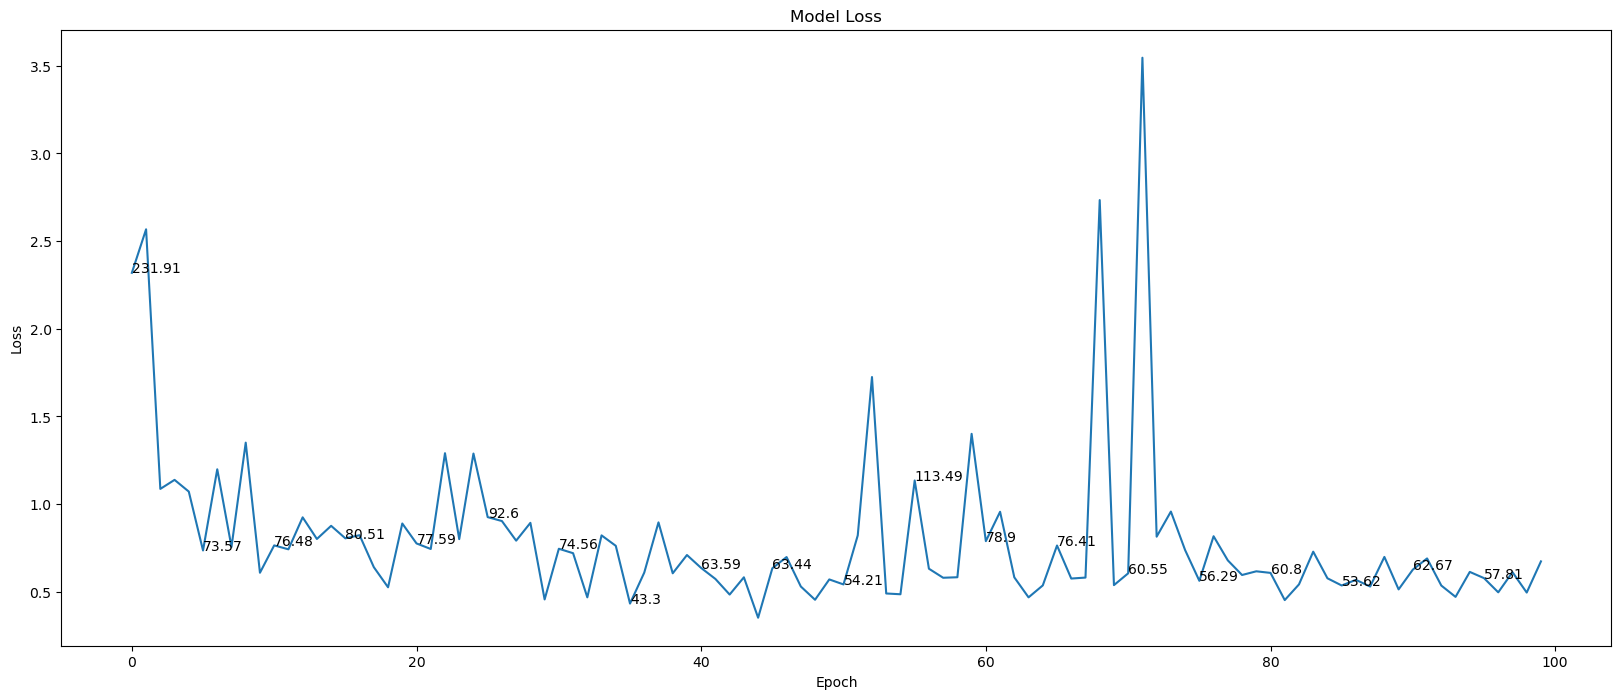

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()